## Requirements

In [1]:
# Import libraries
## Data
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import scipy.stats as st

## Visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from webcolors import rgb_to_hex

## Bert transformer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## Utils
import warnings
from tqdm.notebook import tqdm
import time
from geopy.distance import distance
import requests
from sklearn.preprocessing import MinMaxScaler

## Clustering
### Clustering index
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import kneed
## Algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, estimate_bandwidth, MeanShift
import hdbscan
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

## Maps
import folium
from folium import Marker, Circle

## Datetime
from suntime import Sun 
from datetime import datetime, timedelta
from dateutil import tz

# Set a style to our plots
plt.style.use('ggplot')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
pd.options.mode.chained_assignment = None

## Import data

In [3]:
base_map =  r"gdrive/MyDrive/Parcours recherche/"
ile_de_france_path_feather = "Flicker_IleDeFrance_total.feather"

dataset = pd.read_feather(ile_de_france_path_feather)

## Helper functions

In [6]:
def clean(x):
    if x is None or x=="\\N":
        return np.NaN
    elif  "/" in x:
        x_split = x.split("/")
        nb1 = float(x_split[0])
        nb2 = x_split[1]
        nb2 = float(nb2.split(" ")[0])
        if nb2 != 0:
            return round(nb1/nb2,1)
        else:
            return np.NaN
    else:
        return x

In [7]:
def WGSS(values, labels):
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values.flatten(),"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    WGSS_val = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        WGSS_val += sum(np.linalg.norm(m_g, axis=1)**2)
    return WGSS_val

def Ball_hall(values, labels):
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values,"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    Ball_hall_index = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        Ball_hall_index += sum(np.linalg.norm(m_g, axis=1)**2)/m_g.shape[0]
    return Ball_hall_index/G.shape[0]

def Banfeld_Raftery(values, labels):
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values,"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    banfeld_raftery_index = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        banfeld_raftery_index += m_g.shape[0]*np.log(sum(np.linalg.norm(m_g, axis=1)**2)/m_g.shape[0])
    return banfeld_raftery_index

In [8]:
def one_dim_gmm(values):
    min_val = 2
    max_val = 10
    step_val = 1

    davies_bouldains = []    
    K = range(min_val,max_val,step_val)
    for k in K:
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(values)
        davies_bouldains.append(davies_bouldin_score(values,
                           labels))
        
    davies_bouldain_value = np.argmax(davies_bouldains)+2
    gmm = GaussianMixture(n_components=davies_bouldain_value)
    labels = gmm.fit_predict(values)
    return labels

def one_dim_kmeans(values, max=10):
    min_val = 2
    max_val = 10
    step_val = 1

    davies_bouldains = []
    K = range(min_val,max_val,step_val)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        labels = kmeanModel.fit_predict(values)
        davies_bouldains.append(davies_bouldin_score(values,
                           labels))

    davies_bouldain_value = np.argmax(davies_bouldains)+2

    kmeanModel = KMeans(n_clusters=davies_bouldain_value)
    labels = kmeanModel.fit_predict(values)
    return labels

def one_dim_meanshift(values):
    meanshift_ = MeanShift(bandwidth=estimate_bandwidth(values))
    labels = meanshift_.fit_predict(values)
    return labels

def one_dim_agglomerative(values):
    min_val = 2
    max_val = 10
    step_val = 1

    davies_bouldains = []
    K = range(min_val,max_val,step_val)
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(values)
        davies_bouldains.append(davies_bouldin_score(values,agg.labels_))

    davies_bouldain_value = np.argmax(davies_bouldains)+2
    agg = AgglomerativeClustering(n_clusters=davies_bouldain_value)
    labels = agg.fit_predict(values)
    return labels

In [9]:
def one_dim_gmm(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []    
    K = range(min_val,max_val,step_val)
    for k in K:
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(values)
        silhouettes.append(silhouette_score(values,
                           labels))
        
    silhouette_value = np.argmax(silhouettes)+2
    gmm = GaussianMixture(n_components=silhouette_value)
    labels = gmm.fit_predict(values)
    return labels

def one_dim_kmeans(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []
    K = range(min_val,max_val,step_val)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        labels = kmeanModel.fit_predict(values)
        silhouettes.append(silhouette_score(values,
                           labels))

    silhouette_value = np.argmax(silhouettes)+2

    kmeanModel = KMeans(n_clusters=silhouette_value)
    labels = kmeanModel.fit_predict(values)
    return labels

def one_dim_meanshift(values):
    meanshift_ = MeanShift(bandwidth=estimate_bandwidth(values))
    labels = meanshift_.fit_predict(values)
    return labels

def one_dim_agglomerative(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []
    K = range(min_val,max_val,step_val)
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(values)
        silhouettes.append(silhouette_score(values,agg.labels_))

    silhouette_value = np.argmax(silhouettes)+2
    agg = AgglomerativeClustering(n_clusters=silhouette_value)
    labels = agg.fit_predict(values)
    return labels

In [10]:
def one_dim_gmm(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []    
    K = range(min_val,max_val,step_val)
    for k in K:
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(values)
        silhouettes.append(silhouette_score(values,
                           labels))
        
    silhouette_value = np.argmax(silhouettes)+2
    gmm = GaussianMixture(n_components=silhouette_value)
    labels = gmm.fit_predict(values)
    return labels

def one_dim_kmeans(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []
    K = range(min_val,max_val,step_val)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        labels = kmeanModel.fit_predict(values)
        silhouettes.append(silhouette_score(values,
                           labels))

    silhouette_value = np.argmax(silhouettes)+2

    kmeanModel = KMeans(n_clusters=silhouette_value)
    labels = kmeanModel.fit_predict(values)
    return labels

def one_dim_meanshift(values):
    meanshift_ = MeanShift(bandwidth=estimate_bandwidth(values))
    labels = meanshift_.fit_predict(values)
    return labels

def one_dim_agglomerative(values):
    min_val = 2
    max_val = 10
    step_val = 1

    silhouettes = []
    K = range(min_val,max_val,step_val)
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(values)
        silhouettes.append(silhouette_score(values,agg.labels_))

    silhouette_value = np.argmax(silhouettes)+2
    agg = AgglomerativeClustering(n_clusters=silhouette_value)
    labels = agg.fit_predict(values)
    return labels

In [11]:
def one_dim_gmm(values):
    min_val = 2
    max_val = 10
    step_val = 1

    wgss = []    
    K = range(min_val,max_val,step_val)
    for k in K:
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(values)
        wgss.append(WGSS(values,
                         labels))
        
    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee
    gmm = GaussianMixture(n_components=elbow_point)
    labels = gmm.fit_predict(values)
    return labels

def one_dim_kmeans(values, max=10):
    min_val = 2
    max_val = max
    step_val = 1

    wgss = []
    K = range(min_val,max_val,step_val)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(values)
        wgss.append(kmeanModel.inertia_)

    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee

    kmeanModel = KMeans(n_clusters=elbow_point)
    labels = kmeanModel.fit_predict(values)
    return labels

def one_dim_meanshift(values):
    meanshift_ = MeanShift(bandwidth=estimate_bandwidth(values))
    labels = meanshift_.fit_predict(values)
    return labels

def one_dim_agglomerative(values):
    min_val = 2
    max_val = 10
    step_val = 1

    wgss = []
    K = range(min_val,max_val,step_val)
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(values)
        wgss.append(WGSS(values,agg.labels_))

    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee
    agg = AgglomerativeClustering(n_clusters=elbow_point)
    labels = agg.fit_predict(values)
    return labels

In [12]:
class spot_recommendation_method:
    def __init__(self, method, second_clustering, parameters, need_eps, df, coords_mon):
        self.df = df
        self.method = method
        self.parameters = parameters
        self.need_eps = need_eps
        self.second_clustering = second_clustering
        self.coords_mon = coords_mon

        if self.need_eps:
            self.name_eps = "cluster_selection_epsilon" if self.method is hdbscan.hdbscan_.HDBSCAN else "eps"
        self.clusters = None
        self.trained = False
        self.new_df = None

        self.scaled_df = self.df.copy(deep=True)
        self.scaled_df.loc[:,["latitude","longitude"]] = self.__scaled(self.df[["latitude","longitude"]])
        self.elapsed_times = dict()
    
    def __scaled(self, X):
        minmax_sc = MinMaxScaler()
        return minmax_sc.fit_transform(X)

    def __find_eps(self):
        neighbors = NearestNeighbors(n_neighbors=2)
        if self.method is hdbscan.hdbscan_.HDBSCAN:
            neighbors_fit = neighbors.fit(np.radians(self.df[["latitude", "longitude"]]))
            distances, indices = neighbors_fit.kneighbors(np.radians(self.df[["latitude", "longitude"]]))
        else:
            neighbors_fit = neighbors.fit(self.df[["latitude", "longitude"]])
            distances, indices = neighbors_fit.kneighbors(self.df[["latitude", "longitude"]])
        distances = np.sort(distances, axis=0)[:,1]
        distance_stric_pos = distances[distances>0]

        ## Find the kneedle of the elbow curve
        diff_distance = distances.shape[0] - distance_stric_pos.shape[0]
        x,y = np.arange(distance_stric_pos.shape[0]) ,distance_stric_pos
        kneedle = kneed.KneeLocator(x,y,curve="convex")
        knee_point = diff_distance + kneedle.knee
        self.eps = distances[knee_point]

    def __compute_method(self):
        #If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).
        if self.need_eps:
            self.__find_eps()            
            self.parameters[self.name_eps]=float(self.eps)
        init = time.process_time()
        clusters_detection = self.method(**self.parameters)
        self.elapsed_times["Global"] = time.process_time() - init
        self.clusters = clusters_detection.fit_predict(self.scaled_df[["latitude","longitude"]])
        self.df["Clusters"] = self.clusters
        self.scaled_df["Clusters"] = self.clusters

    def __delete_outliers(self):
        ## First, we delete outliers found by DBSCAN
        df_without_outliers = self.df[self.df.Clusters != -1]
        
        self.df.drop(['Clusters'], axis=1, inplace=True)

        ## Then we delete all clusters>=3 with unique coordinates
        df_without_outliers_vc = df_without_outliers.Clusters.value_counts()
        df_without_outliers_vc = df_without_outliers_vc[df_without_outliers_vc>=3].reset_index()

        index_1 = list()
        for index in df_without_outliers_vc["index"].values:
            val = df_without_outliers[df_without_outliers.Clusters == index][["latitude","longitude"]].value_counts().index.shape[0]
            if val == 1:
                index_1.append(index)

        ## Delete both outliers
        self.new_df = df_without_outliers[~df_without_outliers.Clusters.isin(index_1)]

    def get_angle(self, row):
        lat_cart = row["latitude"] - self.coords_mon[0]
        long_cart = row["longitude"] - self.coords_mon[1]
        lat_city = 48.856614
        return np.arctan(long_cart/lat_cart)

    def __second_clustering(self):
        # Step 4: 2nd clustering On the main Cluster
        lat_mon, long_mon = self.df[["latitude","longitude"]]

        self.main_cluster = self.new_df.Clusters.value_counts().index[0]
        self.df_without_outliers_first = self.new_df[self.new_df.Clusters==self.main_cluster]
        self.df_without_first = self.new_df[self.new_df.Clusters!=self.main_cluster]

        ### Definition of Angle and Distance
        self.distances_to_mon = self.__scaled(np.array([distance((self.coords_mon[0], self.coords_mon[1]),
                                                            (self.df_without_outliers_first.loc[j,"latitude"], self.df_without_outliers_first.loc[j,"longitude"])).m for j in self.df_without_outliers_first.index]).reshape(-1, 1))
        self.angles = self.__scaled(self.df_without_outliers_first[["latitude","longitude"]].apply(self.get_angle,axis=1).values.reshape(-1, 1))

        local_clustering_methods = [one_dim_agglomerative,one_dim_meanshift,one_dim_kmeans,one_dim_gmm]
        local_clustering_method_names = ["AGNES","Meanshift","KMeans","GMM"]

        for name, method in zip(local_clustering_method_names, local_clustering_methods):
            init = time.process_time()
            self.df_without_outliers_first[f"label_angle_{name}"] = method(self.angles)
            elapsed_time_angle = time.process_time() - init
            init = time.process_time()
            self.df_without_outliers_first[f"label_Distance_{name}"] = method(self.distances_to_mon)
            elapsed_time_distance = time.process_time() - init
            self.elapsed_times[f"Local_{name}"] = elapsed_time_angle + elapsed_time_distance

            k = self.df_without_outliers_first[f"label_angle_{name}"].nunique()
            self.df_without_outliers_first[f"intersect_clusters_{name}"] = self.df_without_outliers_first[[f"label_Distance_{name}",f"label_angle_{name}"]].apply(lambda x: x[f"label_Distance_{name}"]*k + x[f"label_angle_{name}"], axis=1)

            ## Step 5: Merging of all results
            nb_clusters = self.df_without_outliers_first[f"intersect_clusters_{name}"].nunique()
            self.new_df[f"Clusters_{name}"] = self.new_df.Clusters.apply(lambda x: x+nb_clusters if x>self.main_cluster else x)
            self.scaled_df[f"Clusters_{name}"] = self.scaled_df.Clusters.apply(lambda x: x+nb_clusters if x>self.main_cluster else x)
            new_clusters = self.df_without_outliers_first[f"intersect_clusters_{name}"].apply(lambda x:x+self.main_cluster)
            self.new_df.loc[self.df_without_outliers_first.index, f"Clusters_{name}"] = new_clusters
            self.scaled_df.loc[self.df_without_outliers_first.index, f"Clusters_{name}"] = new_clusters
    
    def train(self):
        self.trained = True
        self.__compute_method()
        self.__delete_outliers()
        if self.second_clustering:
            self.__second_clustering()

    def __setup_display(self):
        df_mean_coords = self.new_df.groupby("Clusters")[["latitude","longitude"]].mean().reset_index().rename({"latitude":"mean_latitude",
                                                                                                                "longitude":"mean_longitude"}, axis=1)
        self.new_df = pd.merge(self.new_df, 
                               df_mean_coords, 
                               how='inner',
                               on=['Clusters'])
        distances = list()
        for _, row in self.new_df.iterrows():
            distances.append(distance(row[["latitude","longitude"]],
                                      row[["mean_latitude","mean_longitude"]]).m)
        self.new_df["Distance_Center"] = distances

        df_radius = self.new_df.groupby("Clusters")["Distance_Center"].max().reset_index().rename({"Distance_Center": "Radius"}, axis=1)

        self.new_df = pd.merge(self.new_df, 
                               df_radius, 
                               how='inner',
                               on=['Clusters'])

    def display_result(self, save=True, name="map.html"):
        if self.trained:
            self.__setup_display()
            name = 'Arc de Triomphe'

            colors_viridis = list()
            m = cm.get_cmap('viridis', max(self.new_df["Clusters"]) + 2).colors
            for r in m:
                colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
            np.random.shuffle(colors_viridis)

            m = folium.Map(location=self.coords_mon, tiles='openstreetmap', zoom_start=15)
            Marker(self.coords_mon).add_to(m)
            for lat, long, cluster in self.new_df[["latitude","longitude","Clusters"]].values:
                Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

            for cluster in self.new_df.Clusters.unique():
                data_row = self.new_df[self.new_df.Clusters==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
                mean_lat = data_row.mean_latitude
                mean_long = data_row.mean_longitude
                rad = data_row.Radius
                folium.map.Marker(
                [mean_lat, mean_long],
                icon=folium.features.DivIcon(
                    html=f'<div style="font-size: 12pt; font-weight: bold">{cluster}</div>',
                    )
                ).add_to(m)

            if save:
                m.save(name)
            return m
        else:
            raise Exception("You must call the train function before display the result")
            
    def evaluate_python(self):
        if self.trained:
            self.eval_python = {
                "all": {
                        "silhouette": silhouette_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"]),
                        "calinski_harabasz": calinski_harabasz_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"]),
                        "davies_bouldin": davies_bouldin_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"])
                }
            }
            if self.second_clustering:
                coeff_first = srm.df_without_outliers_first.shape[0]/srm.new_df.shape[0]
                coeff_all_except_first = srm.df_without_first.shape[0]/srm.new_df.shape[0]

                silhouette_all_except_first = silhouette_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                calinski_harabasz_all_except_first = calinski_harabasz_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                davies_bouldin_all_except_first = davies_bouldin_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                
                self.eval_python["second"] = {
                        "silhouette": silhouette_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"]),
                        "calinski_harabasz": calinski_harabasz_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"]),
                        "davies_bouldin": davies_bouldin_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"])
                }
                self.eval_python["sum"] = {
                        "silhouette": coeff_first*self.eval_python["second"]["silhouette"] + coeff_all_except_first*silhouette_all_except_first,
                        "calinski_harabasz": coeff_first*self.eval_python["second"]["calinski_harabasz"] + coeff_all_except_first*calinski_harabasz_all_except_first,
                        "davies_bouldin": coeff_first*self.eval_python["second"]["davies_bouldin"] + coeff_all_except_first*davies_bouldin_all_except_first
                }
        else:
            raise Exception("You must call the train function before display the result") 

In [13]:
def create_tab(location,names,list_maps):
    tb = widgets.TabBar(names, location=location)
    for name, map in zip(names,list_maps):
        with tb.output_to(name):
            htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
                       .format(map.get_root().render().replace('"', '&quot;'),500,500))
            display(htmlmap)

def create_map(coords_mon,df):
    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long in df[["latitude","longitude"]].values:
        Circle([lat,long], radius=5).add_to(m)
    return m

In [14]:
def get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_names, type_):
    df_local_eval = pd.DataFrame()
    for name in cluster_names:
        indice_scores = list()
        if df[name].nunique() > 1:
            for indice in indices:
                indice_score = indice(df[["latitude","longitude"]],
                                      df[name])
                indice_scores.append(indice_score)
            df_local_eval[name] = indice_scores
        else:
            print(f"{name} has predicted only 1 label")
    df_local_eval.index = indice_names
    df_local_eval['strat'] = indice_strats
    df_local_eval.rename({col:f"{type_}_{col.split('_')[-1]}" if len(col.split('_')) > 1 else type_ for col in df_local_eval.columns[:-1]},axis=1, inplace=True)
    df_local_eval['best'] = df_local_eval.apply(lambda x: df_local_eval.iloc[:,:-1].columns[x.loc["strat"](x.iloc[:-1])], axis=1)
    df_local_eval['strat'] = indice_strat_names
    return df_local_eval

In [15]:
def display_local(cluster_names, df, type_, display_cluster_nb=True, custom_colors=False):
    nrow = 1
    ncol = 4
    color_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    fig, axes = plt.subplots(nrow, ncol, figsize=(24,6))
    for c in range(ncol):
        name = cluster_names[c]
        if custom_colors:
            if len(color_list) > df[name].max():
                axes[c].scatter(df.latitude, df.longitude, c=df[name].apply(lambda x: color_list[x]))
            else:
                print("Impossible to apply custom_colors, default color applied")
                axes[c].scatter(df.latitude, df.longitude, c=df[name])
        else:
            axes[c].scatter(df.latitude, df.longitude, c=df[name])
        axes[c].set_title(f"{name.split('_')[-1]} - {df[name].nunique()} clusters")
        axes[c].set_xlabel("Latitude")
        axes[c].set_ylabel("Longitude")
        if display_cluster_nb:
            for (lat, long, cluster) in np.array([df[["latitude","longitude", name]][df[name] == val].iloc[0].values for val in df[name].unique()]):
                axes[c].text(lat, long, str(int(cluster)), color="red", fontsize=20)
    fig.suptitle(f"Local clustering - {type_}", fontsize="xx-large", fontweight="bold")
    fig.tight_layout(pad=4)
    fig.show()

In [16]:
def display_localv2(cluster_names, df, type_, display_cluster_nb=True, custom_colors=False):
    nrow = 2
    ncol = 2
    color_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
    for r in range(nrow):
        for c in range(ncol):
            name = cluster_names[r*ncol+c]
            if custom_colors:
                if len(color_list) > df[name].max():
                    axes[r,c].scatter(df.latitude, df.longitude, c=df[name].apply(lambda x: color_list[x]))
                else:
                    print("Impossible to apply custom_colors, default color applied")
                    axes[r,c].scatter(df.latitude, df.longitude, c=df[name])
            else:
                axes[r,c].scatter(df.latitude, df.longitude, c=df[name])
            axes[r,c].set_title(f"{name.split('_')[-1]} - {df[name].nunique()} clusters")
            axes[r,c].set_xlabel("Latitude")
            axes[r,c].set_ylabel("Longitude")
            if display_cluster_nb:
                for (lat, long, cluster) in np.array([df[["latitude","longitude", name]][df[name] == val].iloc[0].values for val in df[name].unique()]):
                    axes[r,c].text(lat, long, str(int(cluster)), color="red", fontsize=20)
        fig.suptitle(f"Local clustering - {type_}", fontsize="xx-large", fontweight="bold")
    fig.tight_layout(pad=4)
    fig.show()
    plt.gca().invert_yaxis()


In [17]:
dict_filter = lambda x, y: dict([(i,x[i]) for i in x if i in set(y)])

#### Preprocessing

In [18]:
fl = dataset["focal_length"].str.strip(" mm")
fl = fl.apply(clean)
fl = pd.to_numeric(fl, errors="coerce")
dataset["focal_length"] = fl

In [19]:
av = dataset["aperture_value"].str.strip(" mm")
av = av.apply(clean)
av = pd.to_numeric(av, errors="coerce")
dataset["aperture_value"] = av

In [20]:
# Select features
selected_dataset = dataset[["owner_id","date_taken","title", "longitude", "latitude", "tags", "aperture_value", "shutter_speed", "focal_length", "model"]]
selected_dataset.loc[:,"date_taken"] = pd.to_datetime(selected_dataset.date_taken, errors='coerce')

# Drop na
selected_dataset.dropna(axis=0,subset=["title", "date_taken"], inplace=True)
selected_dataset.reset_index(drop=True, inplace=True)

In [21]:
# Display all the monuments from the city / departement
city_name = "Paris"
#dataset[dataset.name_3 == "Versailles"].title.value_counts().iloc[:20]
dataset[dataset.name_2 == city_name].title.value_counts().iloc[:20]

Paris                   50045
Eiffel Tower            10547
Notre Dame               9930
Louvre                   9654
Paris, France            8390
Tour Eiffel              6487
upload                   6159
Arc de Triomphe          5005
Montmartre               3686
Musée du Louvre          3650
Notre Dame de Paris      3432
paris                    3168
.                        2611
Parigi                   2301
The Louvre               2142
Sacre Coeur              2095
Place de la Concorde     2074
Musée d Orsay            1984
PARIS                    1913
Jardin du Luxembourg     1892
Name: title, dtype: int64

In [22]:
# Select the POI
selected_POI_names = ["Louvre","Arc de Triomphe","Notre Dame","Eiffel Tower","Montmartre"]

In [23]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [24]:
# Select the monuments (different from the POI)
selected_monuments_names = ["Louvre","Arc de Triomphe","Notre Dame","Eiffel Tower"]

# Change name for monuments with the same title
selected_dataset_mon_name = selected_dataset.title.value_counts()
selected_dataset_mon_name = selected_dataset_mon_name[selected_dataset_mon_name>100]
all_monument_names = np.array(list(selected_dataset_mon_name.index))

all_names = dict()

l = [3,8,2,1]
sim_ = [0.85,0.85,0.85,0.85]
i=0
sentence_embeddings = model.encode(all_monument_names)

for name in selected_monuments_names:

    sim = cosine_similarity(
        [sentence_embeddings[l[i]]],
        sentence_embeddings
    )

    indexes = np.argwhere(sim[0]>sim_[i])

    all_names[name] = all_monument_names[indexes]
    i+=1

for name in tqdm(selected_monuments_names):
    selected_dataset.loc[:, "title"] = selected_dataset.title.apply(lambda x: name if x in all_names[name] else x)

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
# Create a dataframe for each monuments and stock them in a dict
df_monuments_dict = {title:selected_dataset[selected_dataset.title==title] for title in selected_POI_names}

In [26]:
# Group by spot
df_monuments_spot_dict = dict()
for name, df in df_monuments_dict.items():
    img_nb_df = pd.DataFrame(df.groupby(["latitude","longitude"])["latitude"].count())
    usr_nb_df = pd.DataFrame(df.groupby(["latitude","longitude"])["owner_id"].nunique())
    img_nb_df.rename(columns={"latitude": "Image_count"}, inplace=True)
    usr_nb_df.rename(columns={"idUser": "User_count"}, inplace=True)
    df_img_usr = pd.concat([img_nb_df, usr_nb_df], axis=1)
    df_monuments_spot_dict[name] = df_img_usr.sort_values(by="Image_count", ascending=False).reset_index(level=[0,1])

In [27]:
# Delete photos with photos taken at the same moment by the same user and update
for name in tqdm(df_monuments_dict.keys()):
    for coords in tqdm(df_monuments_spot_dict[name][["latitude", "longitude"]].values):
        df = df_monuments_dict[name][(df_monuments_dict[name]["latitude"] == coords[0]) & \
                                        (df_monuments_dict[name]["longitude"] == coords[1])]

        img_count = df_monuments_spot_dict[name][(df_monuments_spot_dict[name]["latitude"] == coords[0]) & (df_monuments_spot_dict[name]["longitude"] == coords[1])].Image_count.iloc[0]
        usr_count = df_monuments_spot_dict[name][(df_monuments_spot_dict[name]["latitude"] == coords[0]) & (df_monuments_spot_dict[name]["longitude"] == coords[1])].owner_id.iloc[0]

        if (df.shape[0] > 1) and (img_count != usr_count):
            diff_usr = df.owner_id.value_counts()
            #diff_usr = diff_usr[diff_usr > 1]

            for user in diff_usr.index.values:
                indexes = df[df.owner_id == user].index.values
                indexes_to_delete = set()
                
                df_usr = df[df.owner_id == user]
                for i in range(len(indexes)):
                    for j in indexes[i+1:]:
                        df_usr_date = df_usr.date_taken
                        r = max(df_usr_date.loc[indexes[i]],df_usr_date.loc[j]) - min(df_usr_date.loc[indexes[i]],df_usr_date.loc[j])
                        if r.days == 0 and r.seconds < 60*60*5:
                            indexes_to_delete.add(j)
                if len(indexes_to_delete) > 0:
                    df_monuments_dict[name].drop(index=indexes_to_delete, inplace=True, errors="ignore")
for df in df_monuments_dict.values():
    df.reset_index(drop=True,inplace=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6071 [00:00<?, ?it/s]

  0%|          | 0/2639 [00:00<?, ?it/s]

  0%|          | 0/4731 [00:00<?, ?it/s]

  0%|          | 0/9624 [00:00<?, ?it/s]

  0%|          | 0/2201 [00:00<?, ?it/s]

In [28]:
df_monuments_dict["Eiffel Tower"]

,owner_id,date_taken,title,longitude,latitude,tags,aperture_value,shutter_speed,focal_length,model
0,29007352@N08,2006-12-09 18:55:02,Eiffel Tower,2.43467,48.8295,panorama paris tower garden tour view louvre p...,3.5,10/150,18.0,NIKON CORPORATION;NIKON D50
1,24230350@N04,2007-01-05 17:01:17,Eiffel Tower,2.37305,48.8503,paris france europe visit,2.8,1/8,7.5,EASTMAN KODAK COMPANY;KODAK EASYSHARE V803 ZO
2,48547368@N07,2010-07-05 12:25:37,Eiffel Tower,2.38335,48.8375,paris torreeiffel francia sena riosena,9.0,1/250,21.0,Canon;Canon EOS 50D
3,51944568@N05,2010-12-27 19:03:15,Eiffel Tower,2.39380,48.8277,,NaN,\N,NaN,\N
4,62126022@N04,2009-04-14 22:11:12,Eiffel Tower,2.36944,48.8449,,NaN,\N,NaN,\N
...,...,...,...,...,...,...,...,...,...,...
17776,148630969@N03,2012-11-03 18:36:30,Eiffel Tower,2.34158,48.8861,france îledefrance paris,NaN,\N,NaN,\N
17777,148630969@N03,2012-11-03 18:40:35,Eiffel Tower,2.34168,48.8862,france îledefrance paris,NaN,\N,NaN,\N
17778,148630969@N03,2012-11-03 18:46:40,Eiffel Tower,2.34165,48.8862,france îledefrance paris,NaN,\N,NaN,\N
17779,16863090@N00,2018-08-06 21:36:17,Eiffel Tower,2.34281,48.8865,eiffel tower fujifilm xt1 35mm f14r f14 basil...,NaN,\N,NaN,\N


In [29]:
# Create monument table
lats = list()
longs = list()
for name in selected_POI_names:
    name += " " + city_name
    url = f"https://nominatim.openstreetmap.org/search/{'%20'.join(name.split(' '))}?format=json"
    print(url)
    r = requests.get(url).json()
    lats.append(float(r[0]["lat"]))
    longs.append(float(r[0]["lon"]))

# Table creation
monuments_def = pd.DataFrame({
    'Image_nb':[l.shape[0] for l in df_monuments_dict.values()],
    'User_nb':[df.iloc[:,0].unique().shape[0] for df in df_monuments_dict.values()],
    'Latitude':lats,
    'Longitude':longs,
    },
    index=selected_POI_names
)
monuments_def["Popularity_score"] = 100*(monuments_def["Image_nb"] * (monuments_def["User_nb"]/monuments_def["Image_nb"]))/dataset.shape[0]

"""
LIMIT_LOCATIONS = monuments_def.shape[0]
lat_list = list()
long_list = list()
elevation_list = list()
for lat, long in zip(monuments_def.loc[:,"Latitude"],monuments_def.loc[:,"Longitude"]):
    if len(lat_list) < LIMIT_LOCATIONS:
        lat_list.append(lat)
        long_list.append(long)
    if len(lat_list) == LIMIT_LOCATIONS:
        url = "https://api.opentopodata.org/v1/eudem25m?locations="
        count = 0
        for lat, long in zip(lat_list, long_list):
            url += f"{lat},{long}|" if count != LIMIT_LOCATIONS - 1 else f"{lat},{long}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json()['results']
            for ele in results:
                elevation_list.append(ele['elevation'])
            time.sleep(1)
        else:
            raise SystemError(f"Pb API: {response.status_code}, {response.content}")
        lat_list = list()
        long_list = list()

monuments_def["Elevation"] = elevation_list
monuments_def.to_csv(r'monuments_info.csv', index = True, header=True)
monuments_def"""

https://nominatim.openstreetmap.org/search/Louvre%20Paris?format=json
https://nominatim.openstreetmap.org/search/Arc%20de%20Triomphe%20Paris?format=json
https://nominatim.openstreetmap.org/search/Notre%20Dame%20Paris?format=json
https://nominatim.openstreetmap.org/search/Eiffel%20Tower%20Paris?format=json
https://nominatim.openstreetmap.org/search/Montmartre%20Paris?format=json


'\nLIMIT_LOCATIONS = monuments_def.shape[0]\nlat_list = list()\nlong_list = list()\nelevation_list = list()\nfor lat, long in zip(monuments_def.loc[:,"Latitude"],monuments_def.loc[:,"Longitude"]):\n    if len(lat_list) < LIMIT_LOCATIONS:\n        lat_list.append(lat)\n        long_list.append(long)\n    if len(lat_list) == LIMIT_LOCATIONS:\n        url = "https://api.opentopodata.org/v1/eudem25m?locations="\n        count = 0\n        for lat, long in zip(lat_list, long_list):\n            url += f"{lat},{long}|" if count != LIMIT_LOCATIONS - 1 else f"{lat},{long}"\n        response = requests.get(url)\n        if response.status_code == 200:\n            results = response.json()[\'results\']\n            for ele in results:\n                elevation_list.append(ele[\'elevation\'])\n            time.sleep(1)\n        else:\n            raise SystemError(f"Pb API: {response.status_code}, {response.content}")\n        lat_list = list()\n        long_list = list()\n\nmonuments_def["Elev

In [30]:
# Distance from the spot to the monument
for df in df_monuments_dict.values():
    df.reset_index(drop=True,inplace=True)

for i,name in enumerate(df_monuments_dict):
    df_monuments_dict[name]["Distance"] = np.array([distance((monuments_def.loc[name,"Latitude"], monuments_def.loc[name,"Longitude"]),
                                                                    (df_monuments_dict[name].loc[j,"latitude"], df_monuments_dict[name].loc[j,"longitude"])).m \
                                                                    for j in range(df_monuments_dict[name].shape[0])
    ])

#### Eiffel Tower

##### Clustering

In [31]:
name="Eiffel Tower"

df=df_monuments_dict[name]
coords_mon=monuments_def.loc[name][["Latitude","Longitude"]].values

methods=[DBSCAN,DBSCAN,HDBSCAN,HDBSCAN]
parameters_DBSCAN={
    "min_samples": 4, 
    "metric": "mahalanobis", 
    "metric_params": {"V":np.cov(df[["latitude", "longitude"]].T)}
}
parameters_HDBSCAN={
    "min_cluster_size": 4,
}
list_parameters=[parameters_DBSCAN, parameters_DBSCAN, parameters_HDBSCAN, parameters_HDBSCAN]
list_need_eps=[True, True, True, True]
list_second_clustering=[True,False,True,False]
names = ["2Clust_DBSCAN_score","1Clust_DBSCAN_score","2Clust_HDBSCAN_score","1Clust_HDBSCAN_score"]

srm_dict = dict()
for name, method, parameters, need_eps, second_clustering in zip(names, methods,list_parameters,list_need_eps,list_second_clustering):
    srm = spot_recommendation_method(method, second_clustering, parameters, need_eps, df, coords_mon)
    srm.train()
    srm_dict[name] = srm

##### Local comparison

###### HDBSCAN

In [92]:
def display_localv2(cluster_names, df, type_, display_cluster_nb=True, custom_colors=False):
    nrow = 2
    ncol = 2
    color_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
    for r in range(nrow):
        for c in range(ncol):
            name = cluster_names[r*ncol+c]
            if custom_colors:
                if len(color_list) > df[name].max():
                    axes[r,c].scatter(df.latitude, df.longitude, c=df[name].apply(lambda x: color_list[x]))
                else:
                    print("Impossible to apply custom_colors, default color applied")
                    axes[r,c].scatter(df.latitude, df.longitude, c=df[name])
            else:
                axes[r,c].scatter(df.latitude, df.longitude, c=df[name])
            axes[r,c].set_title(f"{name.split('_')[-1]} - {df[name].nunique()} clusters")
            axes[r,c].set_xlabel("Latitude")
            axes[r,c].set_ylabel("Longitude")
            axes[r,c].invert_xaxis()
            axes[r,c].invert_yaxis()
            if display_cluster_nb:
                for (lat, long, cluster) in np.array([df[["latitude","longitude", name]][df[name] == val].iloc[0].values for val in df[name].unique()]):
                    axes[r,c].text(lat, long, str(int(cluster)), color="red", fontsize=20)
        fig.suptitle(f"Local clustering - {type_}", fontsize="xx-large", fontweight="bold")
    fig.tight_layout(pad=1)
    fig.show()

In [94]:
def display_localv2(cluster_names, df, type_, display_cluster_nb=True, custom_colors=False):
    nrow = 2
    ncol = 2
    color_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
    for r in range(nrow):
        for c in range(ncol):
            name = cluster_names[r*ncol+c]
            if custom_colors:
                if len(color_list) > df[name].max():
                    axes[r,c].scatter(df.longitude, df.latitude, c=df[name].apply(lambda x: color_list[x]))
                else:
                    print("Impossible to apply custom_colors, default color applied")
                    axes[r,c].scatter(df.longitude, df.latitude, c=df[name])
            else:
                axes[r,c].scatter(df.longitude, df.latitude, c=df[name])
            axes[r,c].set_title(f"{name.split('_')[-1]} - {df[name].nunique()} clusters")
            axes[r,c].set_xlabel("Longitude")
            axes[r,c].set_ylabel("Latitude")
            if display_cluster_nb:
                for (lat, long, cluster) in np.array([df[["latitude","longitude", name]][df[name] == val].iloc[0].values for val in df[name].unique()]):
                    axes[r,c].text(lat, long, str(int(cluster)), color="red", fontsize=20)
        fig.suptitle(f"Local clustering - {type_}", fontsize="xx-large", fontweight="bold")
    fig.tight_layout(pad=1)
    fig.show()

In [95]:
df = srm_dict["2Clust_HDBSCAN_score"].df_without_outliers_first
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max"]

<ipython-input-94-12669da8c253>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


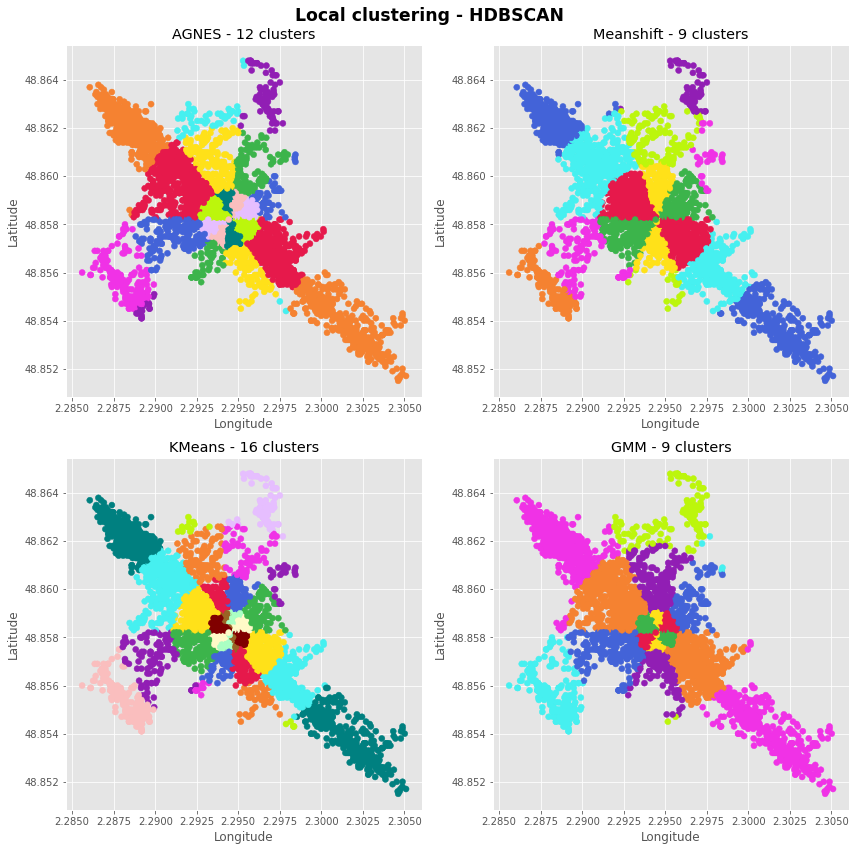

In [96]:
cluster_names = ["intersect_clusters_AGNES","intersect_clusters_Meanshift","intersect_clusters_KMeans","intersect_clusters_GMM"]
display_localv2(cluster_names, df, "HDBSCAN", False, True)

In [31]:
cluster_names = ["intersect_clusters_AGNES","intersect_clusters_Meanshift","intersect_clusters_KMeans","intersect_clusters_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "HDBSCAN")

,HDBSCAN_AGNES,HDBSCAN_Meanshift,HDBSCAN_KMeans,HDBSCAN_GMM,strat,best
WGSS,0.123278,0.122542,0.121535,0.122235,max,HDBSCAN_AGNES
Ball Hall,0.000008,0.000010,0.000008,0.000008,max,HDBSCAN_Meanshift
Banfeld Raftery,-164928.445925,-160150.340576,-167421.233983,-166114.866631,min,HDBSCAN_KMeans
Silhouette,-0.093045,-0.048789,-0.060310,-0.050317,max,HDBSCAN_Meanshift


In [32]:
cluster_names = ["label_angle_AGNES","label_angle_Meanshift","label_angle_KMeans","label_angle_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "Angle")

,Angle_AGNES,Angle_Meanshift,Angle_KMeans,Angle_GMM,strat,best
WGSS,0.145877,0.147144,0.146419,0.147104,max,Angle_Meanshift
Ball Hall,0.000008,0.000008,0.000007,0.000008,max,Angle_GMM
Banfeld Raftery,-145489.278780,-143834.206204,-145105.044840,-143949.807061,min,Angle_AGNES
Silhouette,-0.227970,-0.192160,-0.240850,-0.181870,max,Angle_GMM


In [33]:
cluster_names = ["label_Distance_AGNES","label_Distance_Meanshift","label_Distance_KMeans","label_Distance_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "Distance")

,Distance_AGNES,Distance_Meanshift,Distance_KMeans,Distance_GMM,strat,best
WGSS,0.134266,0.134825,0.134280,0.133912,max,Distance_Meanshift
Ball Hall,0.000018,0.000022,0.000016,0.000016,max,Distance_Meanshift
Banfeld Raftery,-162865.114245,-158019.046977,-165310.240956,-164464.781635,min,Distance_KMeans
Silhouette,0.388452,0.486748,0.295060,0.319204,max,Distance_Meanshift


In [34]:
def setup_map(df_method, cluster_name):
    df_mean_coords = df_method.groupby(cluster_name)[["latitude","longitude"]].mean().reset_index().rename({"latitude":"mean_latitude",
                                                                                                            "longitude":"mean_longitude"}, axis=1)
    df = pd.merge(df_method, 
                  df_mean_coords, 
                  how='inner',
                  on=[cluster_name])
    distances = list()
    for _, row in df.iterrows():
        distances.append(distance(row[["latitude","longitude"]],
                                  row[["mean_latitude","mean_longitude"]]).m)
    df["Distance_Center"] = distances

    df_radius = df.groupby(cluster_name)["Distance_Center"].max().reset_index().rename({"Distance_Center": "Radius"}, axis=1)

    df = pd.merge(df, 
                  df_radius, 
                  how='inner',
                  on=[cluster_name])
    return df

def create_complex_map(df_method, cluster_name, coords_mon):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for cluster in df[cluster_name].unique():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{cluster}</div>',
          )
        ).add_to(m)
    return m

###### DBSCAN

In [35]:
df = srm_dict["2Clust_DBSCAN_score"].df_without_outliers_first
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max"]

<ipython-input-13-bc9d3adb5349>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


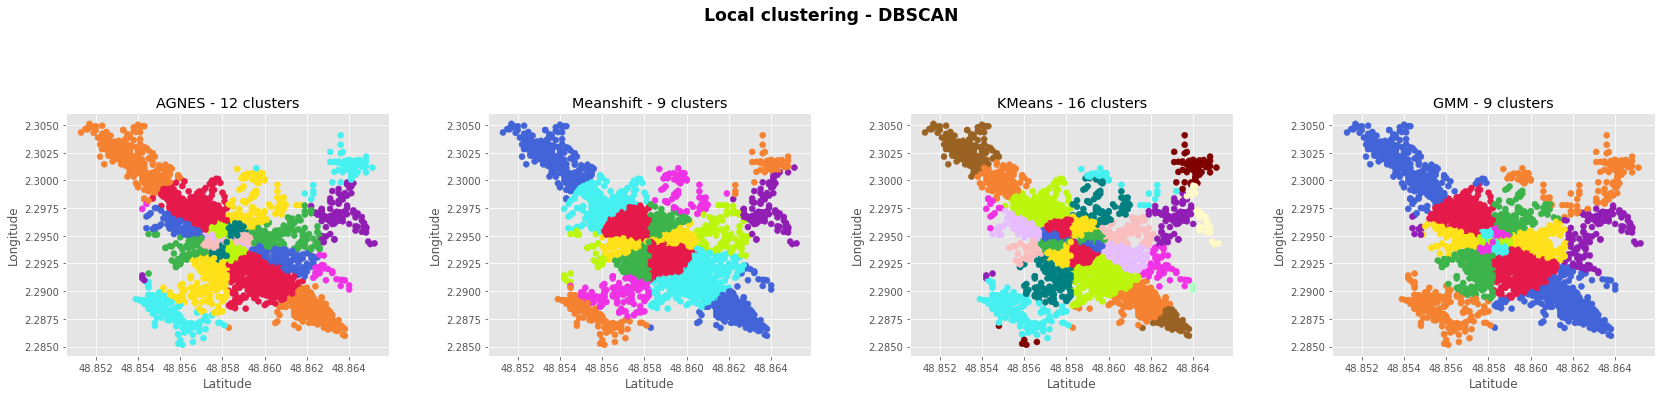

In [36]:
cluster_names = ["intersect_clusters_AGNES","intersect_clusters_Meanshift","intersect_clusters_KMeans","intersect_clusters_GMM"]
display_local(cluster_names, df, "DBSCAN", False, True)

In [37]:
cluster_names = ["intersect_clusters_AGNES","intersect_clusters_Meanshift","intersect_clusters_KMeans","intersect_clusters_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "DBSCAN")

,DBSCAN_AGNES,DBSCAN_Meanshift,DBSCAN_KMeans,DBSCAN_GMM,strat,best
WGSS,0.143752,0.143503,0.117864,0.146244,max,DBSCAN_GMM
Ball Hall,0.000012,0.000017,0.000013,0.000013,max,DBSCAN_Meanshift
Banfeld Raftery,-166606.816533,-161881.914137,-166197.689022,-168060.839470,min,DBSCAN_GMM
Silhouette,-0.126318,-0.063229,-0.110235,-0.067304,max,DBSCAN_Meanshift


In [38]:
cluster_names = ["label_angle_AGNES","label_angle_Meanshift","label_angle_KMeans","label_angle_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "Label")

,Label_AGNES,Label_Meanshift,Label_KMeans,Label_GMM,strat,best
WGSS,0.161890,0.162354,0.161836,0.162561,max,Label_GMM
Ball Hall,0.000009,0.000010,0.000009,0.000010,max,Label_Meanshift
Banfeld Raftery,-146234.186571,-144660.325255,-146437.526055,-145507.958968,min,Label_KMeans
Silhouette,-0.244127,-0.180436,-0.245406,-0.178159,max,Label_GMM


In [39]:
cluster_names = ["label_Distance_AGNES","label_Distance_Meanshift","label_Distance_KMeans","label_Distance_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "Distance")

,Distance_AGNES,Distance_Meanshift,Distance_KMeans,Distance_GMM,strat,best
WGSS,0.150619,0.151047,0.134766,0.151006,max,Distance_Meanshift
Ball Hall,0.000020,0.000023,0.000029,0.000017,max,Distance_KMeans
Banfeld Raftery,-165259.235490,-160556.569100,-164307.582939,-167063.662943,min,Distance_GMM
Silhouette,0.374975,0.469183,0.433228,0.295348,max,Distance_Meanshift


##### Global comparison

In [40]:
results = one_dim_kmeans(df[["latitude","longitude"]],95)

In [41]:
np.unique(results)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [42]:
Ball_hall(df[["latitude","longitude"]],results)

1.4403396984456672e-06

In [43]:
Banfeld_Raftery(df[["latitude","longitude"]],results)

-186097.93892501647

In [44]:
silhouette_score(df[["latitude","longitude"]],results)

0.50687011905568

In [45]:
davies_bouldin_score(df[["latitude","longitude"]],results)

0.6969183292245371

In [46]:
calinski_harabasz_score(df[["latitude","longitude"]],results)

21812.608497177524

**DBSCAN**

In [47]:
df = srm_dict["2Clust_DBSCAN_score"].new_df
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score, davies_bouldin_score, calinski_harabasz_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette", "Davies Bouldin", "Calinski Harabasz"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max", "min", "max"]

In [48]:
cluster_names = ["Clusters", "Clusters_AGNES", "Clusters_Meanshift", "Clusters_KMeans", "Clusters_GMM"]
df_DBSCAN = get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "DBSCAN")
df_DBSCAN

,DBSCAN,DBSCAN_AGNES,DBSCAN_Meanshift,DBSCAN_KMeans,DBSCAN_GMM,strat,best
WGSS,1.804019e-01,0.159707,0.159458,0.133819,0.162199,max,DBSCAN
Ball Hall,5.000148e-07,0.000002,0.000002,0.000002,0.000001,max,DBSCAN_KMeans
Banfeld Raftery,-1.884651e+05,-211980.163637,-207255.261241,-211571.036125,-213434.186573,min,DBSCAN_GMM
Silhouette,1.352307e-01,-0.101039,-0.093318,-0.075623,-0.098868,max,DBSCAN
Davies Bouldin,5.061062e-01,2.942207,1.233048,8.166563,3.201984,min,DBSCAN
Calinski Harabasz,4.395032e+03,4496.586911,4627.531096,5208.208413,4546.851173,max,DBSCAN_KMeans


**HDBSCAN**

In [49]:
df = srm_dict["2Clust_HDBSCAN_score"].new_df
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score, davies_bouldin_score, calinski_harabasz_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette", "Davies Bouldin", "Calinski Harabasz"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max", "min", "max"]

In [50]:
cluster_names = ["Clusters", "Clusters_AGNES", "Clusters_KMeans","Clusters_Meanshift", "Clusters_GMM"]
df_HDBSCAN = get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "HDBSCAN")
df_HDBSCAN

,HDBSCAN,HDBSCAN_AGNES,HDBSCAN_KMeans,HDBSCAN_Meanshift,HDBSCAN_GMM,strat,best
WGSS,0.166602,0.139765,0.138022,0.139030,0.138722,max,HDBSCAN
Ball Hall,0.000011,0.000011,0.000011,0.000011,0.000011,max,HDBSCAN
Banfeld Raftery,-193974.001207,-217908.144684,-220400.932741,-213130.039334,-219094.565389,min,HDBSCAN_KMeans
Silhouette,0.191140,-0.009479,0.001949,0.006766,-0.003527,max,HDBSCAN
Davies Bouldin,0.501908,1.603530,4.120342,0.881090,2.098584,min,HDBSCAN
Calinski Harabasz,4114.600349,4598.831569,4548.650546,4708.605034,4719.258742,max,HDBSCAN_GMM


**Both**

In [51]:
df_time = pd.DataFrame({"DBSCAN":srm_dict["2Clust_DBSCAN_score"].elapsed_times.values(),
                        "HDBSCAN":srm_dict["2Clust_HDBSCAN_score"].elapsed_times.values()},
                      index=srm_dict["2Clust_HDBSCAN_score"].elapsed_times.keys())
df_time["Best"] = df_time.apply(lambda x: df_time.columns[np.argmin(x)],axis=1)
df_time

,DBSCAN,HDBSCAN,Best
Global,0.000000,0.000000,DBSCAN
Local_AGNES,185.875000,105.203125,HDBSCAN
Local_Meanshift,238.937500,139.296875,HDBSCAN
Local_KMeans,38.828125,35.234375,HDBSCAN
Local_GMM,15.796875,13.984375,HDBSCAN


In [52]:
df_both = pd.concat([df_DBSCAN.iloc[:,:-2], df_HDBSCAN.iloc[:,:-2]], axis=1)
df_both["strat"] = indice_strats
df_both["best"] = df_both.apply(lambda x: df_both.iloc[:,:-1].columns[x.loc["strat"](x.iloc[:-1])], axis=1)
df_both["strat"] = indice_strat_name
df_both

,DBSCAN,DBSCAN_AGNES,DBSCAN_Meanshift,DBSCAN_KMeans,DBSCAN_GMM,HDBSCAN,HDBSCAN_AGNES,HDBSCAN_KMeans,HDBSCAN_Meanshift,HDBSCAN_GMM,strat,best
WGSS,1.804019e-01,0.159707,0.159458,0.133819,0.162199,0.166602,0.139765,0.138022,0.139030,0.138722,max,DBSCAN
Ball Hall,5.000148e-07,0.000002,0.000002,0.000002,0.000001,0.000011,0.000011,0.000011,0.000011,0.000011,max,HDBSCAN
Banfeld Raftery,-1.884651e+05,-211980.163637,-207255.261241,-211571.036125,-213434.186573,-193974.001207,-217908.144684,-220400.932741,-213130.039334,-219094.565389,min,HDBSCAN_KMeans
Silhouette,1.352307e-01,-0.101039,-0.093318,-0.075623,-0.098868,0.191140,-0.009479,0.001949,0.006766,-0.003527,max,HDBSCAN
Davies Bouldin,5.061062e-01,2.942207,1.233048,8.166563,3.201984,0.501908,1.603530,4.120342,0.881090,2.098584,min,HDBSCAN
Calinski Harabasz,4.395032e+03,4496.586911,4627.531096,5208.208413,4546.851173,4114.600349,4598.831569,4548.650546,4708.605034,4719.258742,max,DBSCAN_KMeans


**RESULTS**

In [53]:
def setup_map(df_method, cluster_name):
    df_mean_coords = df_method.groupby(cluster_name)[["latitude","longitude"]].mean().reset_index().rename({"latitude":"mean_latitude",
                                                                                                            "longitude":"mean_longitude"}, axis=1)
    df = pd.merge(df_method, 
                  df_mean_coords, 
                  how='inner',
                  on=[cluster_name])
    distances = list()
    for _, row in df.iterrows():
        distances.append(distance(row[["latitude","longitude"]],
                                  row[["mean_latitude","mean_longitude"]]).m)
    df["Distance_Center"] = distances

    df_radius = df.groupby(cluster_name)["Distance_Center"].max().reset_index().rename({"Distance_Center": "Radius"}, axis=1)

    df = pd.merge(df, 
                  df_radius, 
                  how='inner',
                  on=[cluster_name])
    return df

def create_complex_map(df_method, cluster_name, coords_mon):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for cluster in df[cluster_name].unique():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{cluster}</div>',
          )
        ).add_to(m)
    return m

In [54]:
df_dbscan = srm_dict["2Clust_DBSCAN_score"].new_df
df_hdbscan = srm_dict["2Clust_HDBSCAN_score"].new_df 
dfs = [df_dbscan, df_hdbscan]
cluster_names = ["Clusters","Clusters_AGNES","Clusters_Meanshift","Clusters_KMeans","Clusters_GMM"]
coords_mon = srm_dict["2Clust_HDBSCAN_score"].coords_mon

In [55]:
map_names = ["HDBSCAN","HDBSCAN_AGNES","HDBSCAN_Meanshift","HDBSCAN_KMeans","HDBSCAN_GMM","DBSCAN","DBSCAN_AGNES","DBSCAN_Meanshift","DBSCAN_KMeans","DBSCAN_GMM",]
maps = []
for df in dfs:
    for name in cluster_names:
        maps.append(create_complex_map(df, name, coords_mon))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
maps[0].save("index.html")

##### Second clustering

In [ ]:
srm = srm_dict["2Clust_HDBSCAN_score"]
min_val = 2
max_val = 8
step_val = 1
K = range(min_val,max_val,step_val)
indice_names = [["silhouette_angles", "davies_bouldin_angles"],
                ["silhouette_distance_to_mon", "davies_bouldin_distance_to_mon"]]
indice_strats = [np.argmax, np.argmin]

In [ ]:
silhouette_angles = []
silhouette_distance_to_mon = []
davies_bouldin_angles = []
davies_bouldin_distance_to_mon = []
for k in tqdm(K):
    agg = AgglomerativeClustering(n_clusters=k)
    labels_angles = agg.fit_predict(srm.angles)
    labels_distance_to_mon = agg.fit_predict(srm.angles)
    silhouette_angles.append(silhouette_score(srm.angles,
                                              labels_angles))
    silhouette_distance_to_mon.append(silhouette_score(srm.distances_to_mon,
                                                       labels_distance_to_mon))
    
    davies_bouldin_angles.append(davies_bouldin_score(srm.angles,
                                                      labels_angles))
    davies_bouldin_distance_to_mon.append(davies_bouldin_score(srm.distances_to_mon,
                                                               labels_distance_to_mon))
indices = [[silhouette_angles,  davies_bouldin_angles],
           [silhouette_distance_to_mon, davies_bouldin_distance_to_mon]]

label_angles_silhouette = AgglomerativeClustering(n_clusters=np.argmax(silhouette_angles)+min_val).fit_predict(srm.angles)
label_distance_to_mon_silhouette = AgglomerativeClustering(n_clusters=np.argmax(silhouette_distance_to_mon)+min_val).fit_predict(srm.distances_to_mon)
coeff = len(np.unique(label_angles_silhouette))
silhouette_labels = label_distance_to_mon_silhouette*coeff + label_angles_silhouette

label_angles_davies_bouldin = AgglomerativeClustering(n_clusters=np.argmin(davies_bouldin_angles)+min_val).fit_predict(srm.angles)
label_distance_to_mon_davies_bouldin = AgglomerativeClustering(n_clusters=np.argmin(davies_bouldin_distance_to_mon)+min_val).fit_predict(srm.distances_to_mon)
coeff = len(np.unique(label_angles_davies_bouldin))
davies_bouldin_labels = label_distance_to_mon_davies_bouldin*coeff + label_angles_davies_bouldin

coeff = len(np.unique(label_angles_davies_bouldin))
davies_bouldin_silhouette_labels = label_distance_to_mon_silhouette*coeff + label_angles_davies_bouldin

X = srm.df_without_outliers_first[["latitude","longitude"]]
scores_agg = {
    "agg_silhouette":{
        "silhouette": silhouette_score(X,silhouette_labels),
        "davies_bouldain": davies_bouldin_score(X,silhouette_labels),
        "calinski_harabasz": calinski_harabasz_score(X,silhouette_labels)
    },
    "agg_davies_bouldain":{
        "silhouette": silhouette_score(X,davies_bouldin_labels),
        "davies_bouldain": davies_bouldin_score(X,davies_bouldin_labels),
        "calinski_harabasz": calinski_harabasz_score(X,davies_bouldin_labels)
    },
    "agg_davies_bouldin_silhouette":{
        "silhouette": silhouette_score(X,davies_bouldin_silhouette_labels),
        "davies_bouldain": davies_bouldin_score(X,davies_bouldin_silhouette_labels),
        "calinski_harabasz": calinski_harabasz_score(X,davies_bouldin_silhouette_labels)
    }
}

nrow = 2
ncol = 2
fig, axes = plt.subplots(nrow,ncol,figsize=(10,6))
for r in range(nrow):
    for c in range(ncol):
        axes[r,c].plot(K, indices[r][c], linestyle='--', marker='o')
        axes[r,c].set_title(indice_names[r][c])
        axes[r,c].axvline(x=indice_strats[c](indices[r][c])+2,color='gray',linestyle='--')
fig.tight_layout()
fig.show()

In [ ]:
nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow,ncol,figsize=(15,5))
axes[0].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=silhouette_labels)
axes[0].set_title("Silhouette")
axes[1].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=davies_bouldin_silhouette_labels)
axes[1].set_title("Davies_bouldin Angle - Silhouette Distance")
axes[2].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=davies_bouldin_labels)
axes[2].set_title("Davies_bouldin")
fig.suptitle("Kmeans")
fig.show()

In [ ]:
kneed_ = lambda distortions:  kneed.KneeLocator(K,distortions,curve="convex",direction="decreasing").knee-min_val

indice_strats = [np.argmax, np.argmin, kneed_]

silhouette_angles = []
silhouette_distance_to_mon = []
davies_bouldin_angles = []
davies_bouldin_distance_to_mon = []
distortions_angles = []
distortions_distance_to_mon = []
for k in tqdm(K):
    kmean_angles = KMeans(n_clusters=k)
    kmean_distances_to_mon = KMeans(n_clusters=k)
    kmean_angles.fit(srm.angles)
    kmean_distances_to_mon.fit(srm.distances_to_mon)
    labels_angles = kmean_angles.labels_
    labels_distances_to_mon = kmean_distances_to_mon.labels_

    silhouette_angles.append(silhouette_score(srm.angles,
                                              labels_angles))
    silhouette_distance_to_mon.append(silhouette_score(srm.distances_to_mon,
                                                       labels_distances_to_mon))
    
    davies_bouldin_angles.append(davies_bouldin_score(srm.angles,
                                                      labels_angles))
    davies_bouldin_distance_to_mon.append(davies_bouldin_score(srm.distances_to_mon,
                                                               labels_distances_to_mon))
    distortions_angles.append(kmean_angles.inertia_)
    distortions_distance_to_mon.append(kmean_distances_to_mon.inertia_)

indices = [[silhouette_angles, davies_bouldin_angles, distortions_angles],
           [silhouette_distance_to_mon, davies_bouldin_distance_to_mon, distortions_distance_to_mon]]
indice_names = [["silhouette_angles", "davies_bouldin_angles", "distortions_angles"],
                ["silhouette_distance_to_mon", "davies_bouldin_distance_to_mon", "distortions_distance_to_mon"]]


label_angles_silhouette = KMeans(n_clusters=np.argmax(silhouette_angles)+min_val).fit_predict(srm.angles)
label_distance_to_mon_silhouette = KMeans(n_clusters=np.argmax(silhouette_distance_to_mon)+min_val).fit_predict(srm.distances_to_mon)
coeff = len(np.unique(label_angles_silhouette))
silhouette_labels = label_distance_to_mon_silhouette*coeff + label_angles_silhouette

label_angles_davies_bouldin = KMeans(n_clusters=np.argmin(davies_bouldin_angles)+min_val).fit_predict(srm.angles)
label_distance_to_mon_davies_bouldin = KMeans(n_clusters=np.argmin(davies_bouldin_distance_to_mon)+min_val).fit_predict(srm.distances_to_mon)
coeff = len(np.unique(label_angles_davies_bouldin))
davies_bouldin_labels = label_distance_to_mon_davies_bouldin*coeff + label_angles_davies_bouldin

label_angles_distortion = KMeans(n_clusters=kneed_(distortions_angles)+min_val).fit_predict(srm.angles)
label_distance_to_mon_distortion = KMeans(n_clusters=np.argmax(distortions_distance_to_mon)+min_val).fit_predict(srm.distances_to_mon)
coeff = len(np.unique(label_angles_distortion))
distortions_labels = label_distance_to_mon_distortion*coeff + label_angles_distortion

X = srm.df_without_outliers_first[["latitude","longitude"]]
scores_kmeans = {
    "kmeans_silhouette":{
        "silhouette": silhouette_score(X,silhouette_labels),
        "davies_bouldain": davies_bouldin_score(X,silhouette_labels),
        "calinski_harabasz": calinski_harabasz_score(X,silhouette_labels)
    },
    "kmeans_davies_bouldain":{
        "silhouette": silhouette_score(X,davies_bouldin_labels),
        "davies_bouldain": davies_bouldin_score(X,davies_bouldin_labels),
        "calinski_harabasz": calinski_harabasz_score(X,davies_bouldin_labels)
    },
    "kmeans_davies_bouldin_silhouette":{
        "silhouette": silhouette_score(X,davies_bouldin_silhouette_labels),
        "davies_bouldain": davies_bouldin_score(X,davies_bouldin_silhouette_labels),
        "calinski_harabasz": calinski_harabasz_score(X,davies_bouldin_silhouette_labels)
    }
}

nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow,ncol,figsize=(15,6))
for r in range(nrow):
    for c in range(ncol):
        axes[r,c].plot(K, indices[r][c], linestyle='--', marker='o')
        axes[r,c].set_title(indice_names[r][c])
        axes[r,c].axvline(x=indice_strats[c](indices[r][c])+2,color='gray',linestyle='--')
fig.tight_layout()
fig.show()

In [ ]:
nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow,ncol,figsize=(15,5))
axes[0].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=silhouette_labels)
axes[0].set_title("Silhouette")
axes[1].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=davies_bouldin_labels)
axes[1].set_title("Davies_bouldin")
axes[2].scatter(srm.df_without_outliers_first["latitude"],srm.df_without_outliers_first["longitude"], c=distortions_labels)
axes[2].set_title("Distortion")
fig.suptitle("Kmeans")
fig.show()

##### Spot qualification

###### Time of day
La date de prise de vue correspond à l'heure à laquelle la photo a été prise. Elle est extraite de la date EXIF lorsqu'elle est disponible, sinon elle est définie sur l'heure de chargement.

In [32]:
df_time = srm_dict["2Clust_HDBSCAN_score"].new_df

In [34]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('Europe/Paris')

sun_rise_list = list()
sun_dusk_list = list()
for _, row in df_time.iterrows():
    time_zone = row["date_taken"]
    latitude = row["latitude"]
    longitude = row["longitude"]

    sun = Sun(latitude , longitude)
    sun_rise = sun.get_local_sunrise_time(time_zone) 
    sun_rise_utc = sun_rise.replace(tzinfo=from_zone)
    sun_rise = sun_rise_utc.astimezone(to_zone)
    sun_rise_list.append(sun_rise)

    sun_dusk = sun.get_local_sunset_time(time_zone) 
    sun_dusk_utc = sun_dusk.replace(tzinfo=from_zone)
    sun_dusk = sun_dusk_utc.astimezone(to_zone)
    sun_dusk_list.append(sun_dusk)
        
df_time["Sunrise"] = sun_rise_list
df_time["Sundusk"] = sun_dusk_list

df_time.loc[:,"date_taken"] = df_time.date_taken.apply(lambda x: x.replace(tzinfo=tz.gettz('Europe/Paris')))

OSError: [Errno 22] Invalid argument

Definition of 4 periods:
- sunrise (+- 10 min)
- day
- sundusk (+- 20 min)
- night

In [ ]:
day_time_list = list()
for _, x in df_time.iterrows():
    if (x.date_taken > x.Sunrise - timedelta(minutes=20)) & (x.date_taken < x.Sunrise + timedelta(minutes=20)):
        day_time_list.append("Sunrise")
    elif (x.date_taken > x.Sundusk - timedelta(minutes=20)) & (x.date_taken < x.Sundusk + timedelta(minutes=20)):
        day_time_list.append("Sundusk")
    elif (x.date_taken > x.Sunrise + timedelta(minutes=20)) & (x.date_taken < x.Sundusk - timedelta(minutes=20)):
        day_time_list.append("Day")
    else:
        day_time_list.append("Night")
df_time["TimeOfDay"] = day_time_list

In [ ]:
plt.figure(figsize=(25,7))
plt.pie(x=[(10/144)*20, (10/144)*8*60, (10/144)*40, (10/144)*15*60], labels=["Sunrise", "Day", "Sundusk", "Night"], startangle=180, autopct='%1.1f%%')
plt.ylabel("")
plt.title("Repartition of TimeOfDay")
plt.show()

In [ ]:
plt.figure(figsize=(25,7))
df_time.TimeOfDay.value_counts(normalize=True).plot.pie(startangle=180, autopct='%1.1f%%')
plt.ylabel("")
plt.title("Repartition of TimeOfDay")
plt.show()

In [ ]:
df_time.Clusters_Meanshift.nunique()

In [ ]:
indexes = df_time.Clusters_Meanshift.value_counts()[df_time.Clusters_Meanshift.value_counts()>25].index

In [ ]:
df_time_sup_25 = df_time[df_time.Clusters_Meanshift.isin(indexes)]
df_time_sup_25.Clusters_Meanshift.nunique()

In [ ]:
fig, axes = plt.subplots(df_time_sup_25.Clusters_Meanshift.nunique(), 1, figsize=(5,4*df_time_sup_25.Clusters_Meanshift.nunique()))
for i, cluster in enumerate(df_time_sup_25.Clusters_Meanshift.unique()):
    df = df_time_sup_25[df_time_sup_25.Clusters_Meanshift == cluster]
    df.TimeOfDay.value_counts(normalize=True).plot.pie(startangle=180, autopct='%1.1f%%', ax = axes[i])
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_ylabel("")
fig.suptitle("Repartition of TimeOfDay")
fig.tight_layout()
fig.show()

###### Popularity

In [ ]:
popu_df = srm_dict["2Clust_HDBSCAN_score"].new_df[["latitude","longitude","Clusters_Meanshift"]]
pop_df = popu_df.Clusters_Meanshift.value_counts()/popu_df.shape[0]
pop_df = pop_df[:15]
pop_df

In [ ]:
pop_df = pd.DataFrame(pop_df)
pop_df["Rank"] = range(1,pop_df.shape[0]+1)

In [ ]:
pop_df

In [ ]:
popu_df = popu_df[popu_df.Clusters_Meanshift.isin(pop_df.index)]

In [ ]:
def create_complex_map_pop(df_method, cluster_name, coords_mon, ranking):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for _, (cluster, rank) in ranking.iterrows():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{rank}</div>',
          )
        ).add_to(m)
    return m

In [ ]:
popu_df[popu_df.Clusters_Meanshift.isin(pop_df.index)]

###### Panorama

In [ ]:
df_panorama = srm_dict["2Clust_HDBSCAN_score"].new_df

In [ ]:
int_df = pd.merge(df_panorama[["longitude","latitude","Clusters_Meanshift", "aperture_value", "focal_length"]], 
                  dataset[dataset.title != "Eiffel Tower"][["title","longitude","latitude", "aperture_value", "focal_length"]], 
                  how='inner',
                  on=['longitude', 'latitude'])
int_df = int_df.groupby("Clusters_Meanshift").agg({"title": pd.Series.nunique}).reset_index()
int_df.rename({"title":"n_title"}, axis=1, inplace = True)
df_panorama = pd.merge(df_panorama, 
                   int_df, 
                   how='inner',
                   on=['Clusters_Meanshift'])

In [ ]:
pd.DataFrame(df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)).head(30)

In [ ]:
def create_complex_map_pan(df_method, cluster_name, coords_mon):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)
    return m

create_complex_map_pan(df_panorama[df_panorama.Clusters_Meanshift.isin(selected_clusters)],
                       "Clusters_Meanshift",
                       coords_mon)
                       

In [ ]:
pan = 100*df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)/df_panorama.groupby("Clusters_Meanshift").n_title.sum().sum()
pan

In [ ]:
selected_clusters = list(pd.DataFrame(df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)).head(30).index)

In [ ]:
selected_clusters_df = df_panorama[df_panorama.Clusters_Meanshift.isin(selected_clusters)]

In [ ]:
selected_clusters_df.Clusters_Meanshift.unique()

In [ ]:
pd.DataFrame(selected_clusters_df.groupby("Clusters_Meanshift").aperture_value.mean()).sort_values(by="aperture_value")

In [ ]:
pd.DataFrame(selected_clusters_df.groupby("Clusters_Meanshift").focal_length.mean()).sort_values(by="focal_length")

In [ ]:
df_panorama = df_panorama[df_panorama.Clusters_Meanshift.isin(pan[:25].index)]

In [ ]:
def create_complex_map_pan(df_method, cluster_name, coords_mon, panorama):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for _, (cluster, pano) in pd.DataFrame(panorama).reset_index().iterrows():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        Circle([mean_lat,mean_long], radius=rad, weight=pano, color="red").add_to(m)
    return m